## Feature Engineering and Modeling

### Table of Contents

1. [Objective](#1.-Objective)
2. [Import Libraries](#2.-Import-Libraries)
3. [Load the Dataset](#3.-Load-the-Dataset)
4. [Common Variables, Methods Definition](#4.-Common-Variables,-Methods-Definition)
5. [Model Training](#5.-Model-Training)
6. [Preparing the Winning Model, XGBoost](#6.-Preparing-the-Winning-Model,-XGBoost)
    - [6.1 Create a new Datframe with the Selected Features](#6.1-Create-a-new-Datframe-with-the-Selected-Features)
    - [6.2 Add Composite Features into the Dataframe](#6.2-Add-Composite-Features-into-the-Dataframe)
    - [6.3 Prepare Training, Validation, and Test Sets](#6.3-Prepare-Training,-Validation,-and-Test-Sets)
    - [6.4 Hyperparameter Tuning the Model](#6.4-Hyperparameter-Tuning-the-Model)
    - [6.5 Train and Validate the Model with the Optimized Hyperparameter.](#6.5-Train-and-Validate-the-Model-with-the-Optimized-Hyperparameter.)
    - [6.6 Class Imbalance Strategy](#6.6-Class-Imbalance-Strategy)
7. [Adjusting Thresholds Using Cost-Benefit Analysis](#7.-Adjusting-Thresholds-Using-Cost-Benefit-Analysis)
    - [7.1 Derive the Global Cost and Net-Benefit](#7.1-Derive-the-Global-Cost-and-Net-Benefit)
      - [7.1.1 Cost-Benefit Table](#7.1.1-Cost-Benefit-Table)
    - [7.2 Per-Class Cost and Net-Benefits](#7.2-Per-Class-Cost-and-Net-Benefits )
      - [7.2.1 Cost-Benefit Table](#7.2.1-Cost-Benefit-Table)
    - [7.3 Applying the Optimized Thresholds on the Validation Data](#7.3-Applying-the-Optimized-Thresholds-on-the-Validation-Data)
    - [7.4 Applying the Optimized Thresholds on the Test Data](#7.4-Applying-the-Optimized-Thresholds-on-the-Test-Data)
8. [Summary](#8.-Summary)
9. [Recommendations](#9.-Recommendations)
10. [Conclusion](#10.-Conclusion)

### 1. Objective

The objective of this notebook is to develop a robust machine learning classification model for predicting mental health status, specifically targeting the classification of individuals into distinct mental health categories. 

1. **Prepare and Preprocess Data**:
   - Transform raw data into a structured format using feature engineering and preprocessing techniques.
   - Address data imbalances and optimize feature selection for better model performance.

2. **Train and Evaluate Models**:
   - Explore several machine learning algorithms, including Logistic Regression, Random Forest, LightGBM, XGBoost, and CatBoost.
   - Compare performance metrics to identify the most suitable model for deployment.

3. **Optimize Predictions**:
   - Refine the selected classification model using feature engineering and composite features.
   - Implement cost-benefit analysis and per-class thresholding to align predictions with real-world needs.

4. **Ensure Deployment Readiness**:
   - Validate the model's generalizability and effectiveness across test data.
   - Focus on achieving reliable performance for dominant classes ("0 Days" and "1-13 Days") while identifying strategies to mitigate weaknesses in minority classes ("14+ Days" and "Unsure").

The primary goal is to create a reliable and interpretable model capable of supporting decision-making processes in mental health initiatives.

**The Target Classes:**

- **Class 0**: (0 Days) No Mental Stress (59% Prevalence)
  - Overrepresented, making it easier for the model to predict correctly.
- **Class 1**: 1–13 Days of Stress (25% Prevalence)
  - Represents individuals with moderate stress and needs higher priority.
- **Class 2**: 14+ Days of Stress (13% Prevalence)
  - Critical, as it represents individuals with severe and persistent stress.
- **Class 3**: Unsure (<2% Prevalence)
  - Represents uncertainty or missing information, making it less actionable.

**The Dataset:**

See the [EDA](./EDA.ipynb) notebook for description of the features included in the intermediate dataset.

### 2. Import Libraries

In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Set default dataframe behaviors
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', None)
#pd.set_option('display.max_rows', None)

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression 
from lightgbm import LGBMClassifier
import xgboost as xgb

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Autoload local libraries, if any
%reload_ext autoreload
%autoreload 2

import libs.data_utils as utils

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*_check_n_features.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*_check_feature_names.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*__sklearn_tags__.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*_validate_data.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r"This Pipeline instance is not fitted yet.*")


### 3. Load the Dataset

In [2]:
# Load Dataset
mh_df = pd.read_pickle('data/llcp_2022_2023_cleaned.pkl')

In [3]:
mh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 706627 entries, 0 to 709531
Data columns (total 60 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   _STATE    706627 non-null  category
 1   GENHLTH   706627 non-null  category
 2   PHYSHLTH  706627 non-null  int64   
 3   MENTHLTH  706627 non-null  int64   
 4   POORHLTH  706627 non-null  int64   
 5   MEDCOST1  706627 non-null  category
 6   CHECKUP1  706627 non-null  category
 7   EXEROFT1  706627 non-null  category
 8   BPHIGH6   706627 non-null  category
 9   BPMEDS1   706627 non-null  category
 10  CHOLCHK3  706627 non-null  category
 11  CHOLMED3  706627 non-null  category
 12  CVDINFR4  706627 non-null  category
 13  CVDCRHD4  706627 non-null  category
 14  CVDSTRK3  706627 non-null  category
 15  ASTHNOW   706627 non-null  category
 16  CHCSCNC1  706627 non-null  category
 17  CHCOCNC1  706627 non-null  category
 18  CHCCOPD3  706627 non-null  category
 19  ADDEPEV3  706627 non-null  c

### 4. Common Variables, Methods Definition

In [4]:
# The target variable
target = '_MENT14D'

In [5]:
import time
import humanfriendly

# Timer
def get_elapsed(start, end):
  return humanfriendly.format_timespan(end - start)


Preprocessing pipeline definitions

In [6]:
from sklearn.pipeline import Pipeline

## Feature Preprocessing methods

def preprocessor(continuous_features, categorical_features): 
  """Create the transformer, preprocessors"""
  return ColumnTransformer(
    transformers=[
      ('scale', StandardScaler(), continuous_features),
      ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough', force_int_remainder_cols=False
  )

def smote():
  return SMOTE(random_state=42)

def create_pipeline(X, model, continuous_features, categorical_features):
  # Identify catergorical column indexes for SMOTE
  #indices = [X.columns.get_loc(col) for col in categorical_features]
  # Build the pipeline
  return ImbPipeline(steps=[
    ('preprocessor', preprocessor(continuous_features, categorical_features)),
    #('smote', smote()),
    ('classifier', model)
  ])

XGBoost adjusted threshold prediction method.

In [7]:
def xgb_predict_with_threshold(model, x_val, _y_val, thresholds):
  """Predict class probabilities, then apply adjusted threshold"""
  _x_val = xgb.DMatrix(x_val, label=_y_val, enable_categorical=True)

  # Generate predictions
  y_test_prob = model.predict(_x_val)
  y_pred = y_test_prob.argmax(axis=1)  # Convert probabilities to class predictions

  y_pred = np.zeros_like(_y_val)
  for i, probs in enumerate(y_test_prob):
    # Compare probabilities with their respective thresholds
    max_prob = 0
    best_class = None
    for class_label, threshold in thresholds.items():
      if probs[class_label] >= threshold and probs[class_label] > max_prob:
        max_prob = probs[class_label]
        best_class = class_label
    if best_class != None:
      y_pred[i] = best_class

  return y_pred, y_test_prob

### 5. Model Training

This code trains and evaluates four machine learning models:

- Logistic Regression
- Random Forest
- LightGBM
- XGBoost

The selected models offer a balance of simplicity, interpretability, and performance. **Logistic Regression** serves as a baseline due to its ease of implementation and interpretability, though it is limited to linear relationships. **Random Forest** is a versatile ensemble model that handles high-dimensional data well and provides feature importance insights but can be computationally intensive for large datasets.

**LightGBM** and **XGBoost**, two gradient-boosting frameworks, are chosen for their exceptional performance on structured data and ability to handle imbalanced datasets. LightGBM is optimized for speed and efficiency, while XGBoost excels in capturing complex relationships and robustness to missing values. However, both require careful hyperparameter tuning to avoid overfitting. Together, these models enable a comprehensive evaluation to identify the best-performing approach for the given dataset.

The dataset undergoes a preprocessing and transformation pipeline to ensure consistent data handling. The preprocessing steps, aligned with the findings and recommendations from the EDA, include:

- Scaling: Applied to numeric features.
- One-Hot Encoding: Used for categorical features.
- Instead of adopting SMOTENC - Applied for handling class imbalance in categorical features, we will consider class_weights, which does not need to shave or introduce synthetic data to address imbalance. By assigning weights to the classes during the model training phase and make the model more sensitive to underrepresented classes.

Each model is evaluated sequentially, with the model name and performance metrics displayed for comparison using both training and testing datasets.

#### 5.1 Preprocess, Transform the Dataset

In [8]:
# Create feature and target DFs X, y. 

# Define data features

# Numeric features need scaler
continuous_features = ['PHYSHLTH', 'POORHLTH', 'MARIJAN1']
# One-hot encode categoricals
categorical_features = [col for col in mh_df.columns if col not in (continuous_features + [target, 'MENTHLTH'])]

# Copy original DF, drop 'MENTHLTH' 

df = mh_df.drop(columns=['MENTHLTH']).copy()

# Create predictors and target DF.

# Drop MENTHLTH - As recommended in the EDA.
X = df.drop(columns=target)
y = df[target]

# Split into validation, test datasets

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#### 5.2 Logistic Regression

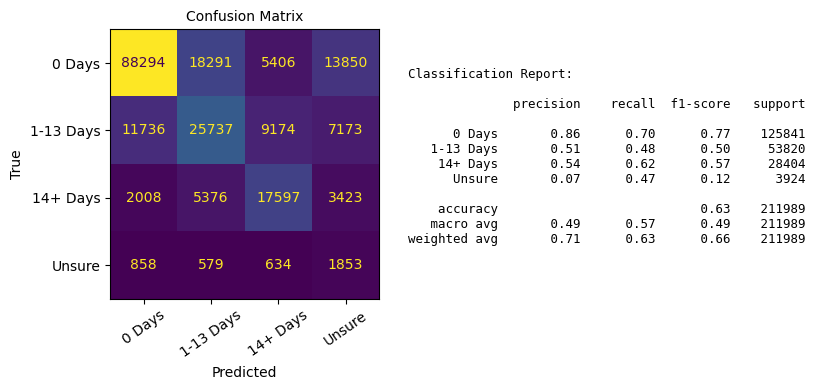

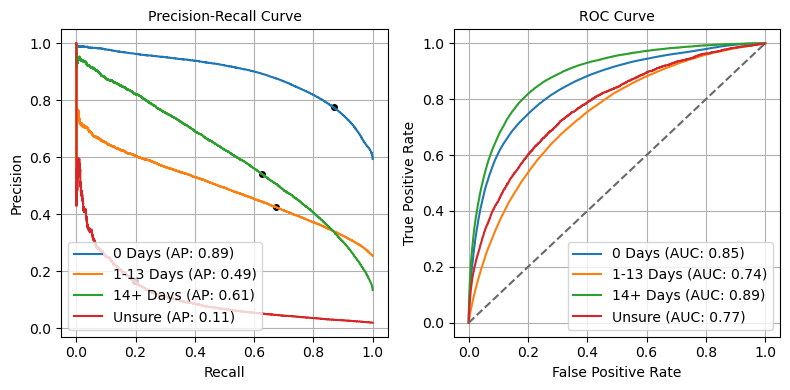

Execution Time: 1 minute and 36.13 seconds.


In [13]:
start = time.perf_counter()

# Define model and pipeline
model_lr = utils.create_logistic_regression_model()
pipel_lr = create_pipeline(X, model_lr, continuous_features, categorical_features)

# Evaluate model
utils.evaluate_model2(pipel_lr, X_train, x_test, y_train, y_test)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

Analysis: Logistic Regression
- Overall Accuracy: 63%
- Macro Avg Precision/Recall/F1: 0.49 / 0.57 / 0.49
- Weighted Avg Precision/Recall/F1: 0.71 / 0.63 / 0.66

Class Performance:
- "0 Days" achieved the highest F1-score (0.77).
- "Unsure" struggled with poor precision and recall (0.07 / 0.47).
- AUC: Highest for "0 Days" (0.85), while "Unsure" (0.77) lagged.

Struggles in minority class detection ("Unsure") with imbalances affecting the recall.

#### 5.3 Random Forest

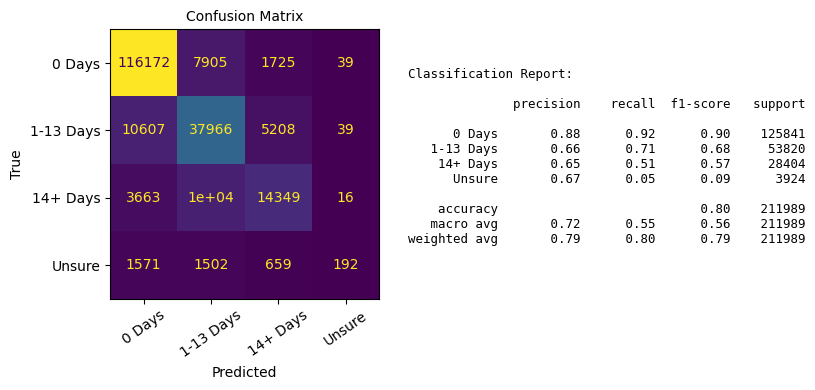

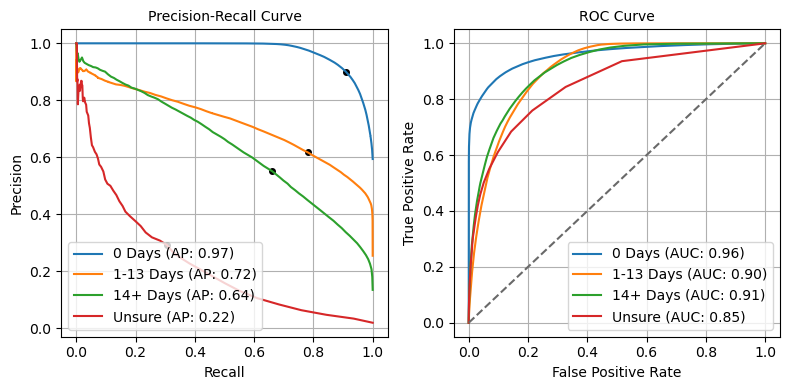

Execution Time: 8 minutes and 6.29 seconds.


In [9]:
start = time.perf_counter()

model_rf = utils.create_random_forest_model()
pipel_rf = create_pipeline(X, model_rf, continuous_features, categorical_features)

utils.evaluate_model2(pipel_rf, X_train, x_test, y_train, y_test)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

Analysis: Random Forest
- Overall Accuracy: 80%
- Macro Avg Precision/Recall/F1: 0.72 / 0.55 / 0.56
- Weighted Avg Precision/Recall/F1: 0.79 / 0.80 / 0.79

Class Performance:
- Consistently strong for "0 Days" (F1 = 0.90) and "1–13 Days" (F1 = 0.68).
- "Unsure" saw slight improvement over Logistic Regression (F1 = 0.09).
- AUC: Better across classes, notably "0 Days" (0.96).

Higher performance across majority classes but continued challenges in "Unsure."

While the Random Forest model achieves high precision for majority classes, its recall across minority classes (e.g., "Unsure" and "14+ Days") is insufficient. This suggests the model is not sensitive enough to detect these cases, likely prioritizing majority class predictions due to class imbalance.

#### 5.4 LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 494638, number of used features: 348
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


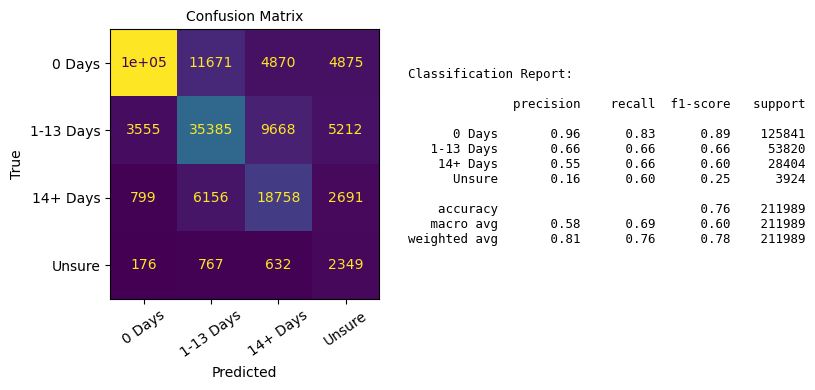

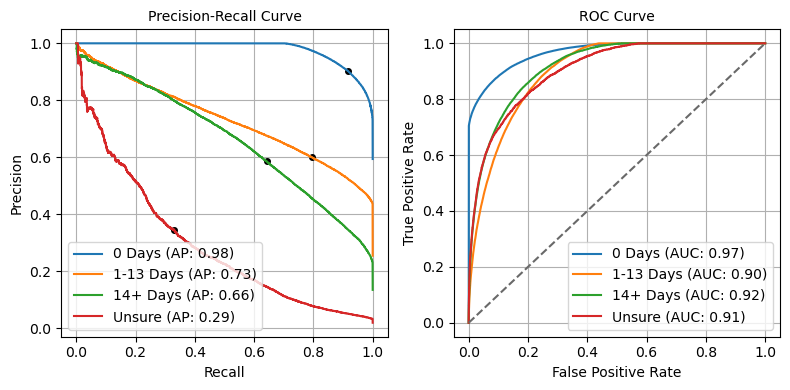

Execution Time: 9.73 seconds.


In [10]:
start = time.perf_counter()

model_lgb = utils.create_lgb_model()
pipel_lgb = create_pipeline(X, model_lgb, continuous_features, categorical_features)

utils.evaluate_model2(pipel_lgb, X_train, x_test, y_train, y_test)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

Analysis: LightGBM
- Overall Accuracy: 76%
- Macro Avg Precision/Recall/F1: 0.58 / 0.69 / 0.60
- Weighted Avg Precision/Recall/F1: 0.81 / 0.76 / 0.78

Class Performance:
- "0 Days" maintains robust F1 (0.89).
- "Unsure" marginally improves (F1 = 0.25).
- AUC: High for "0 Days" (0.97) and acceptable across other classes.

Balanced precision-recall tradeoffs, but issues remain in minority class predictions.

#### 5.5 XGBoost

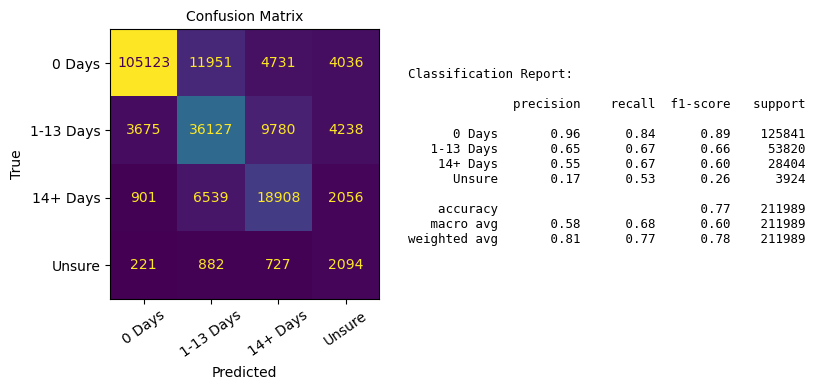

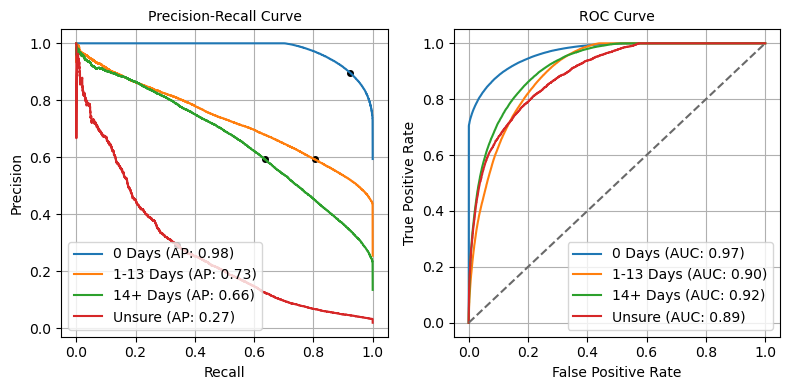

Execution Time: 7.64 seconds.


In [11]:
import xgboost as xgb

start = time.perf_counter()

_y_train = utils.target_label_mapping(y=y_train)
_y_test = utils.target_label_mapping(y=y_test)

# Calculate class weights
class_names = utils.alt_target_class_mapping.values()
class_weights = compute_class_weight('balanced', classes=np.unique(_y_train), y=_y_train)
class_weights_dict = dict(enumerate(class_weights))
sample_weight = np.array([class_weights_dict[class_label] for class_label in _y_train])

# Convert data into DMatrix
dtrain = xgb.DMatrix(X_train, label=_y_train, enable_categorical=True, weight=sample_weight)
dtest = xgb.DMatrix(x_test, label=_y_test, enable_categorical=True)

# Define parameters
params = {
    'eval_metric': 'mlogloss',     # Log-loss for multi-class
    'objective': 'multi:softprob', # Multi-class classification
    'num_class': 4,                # Number of classes
    'random_state': 42,            
    'n_jobs': -1                   # Multi-threaded operation
}

# Train the model
model_xgb = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_probs = model_xgb.predict(dtest)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class predictions

# Plot results
utils.plot_classification_stats2(_y_test, y_pred, class_names, alt=False)
utils.plot_pr_roc_curve(y_test, y_pred_probs)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

Analysis: XGBoost
- Overall Accuracy: 77%
- Macro Avg Precision/Recall/F1: 0.58 / 0.68 / 0.60
- Weighted Avg Precision/Recall/F1: 0.81 / 0.77 / 0.78

Class Performance:
- Comparable F1 scores for majority and minority classes, slightly edging LightGBM.
- "Unsure" achieves similar improvements (F1 = 0.25).
- AUC: Slightly lower for "Unsure" (0.90) compared to LightGBM (0.91).

#### 5.6 Models Performance Summary:



- Logistic Regression: Lowest overall performance (accuracy: 63%), struggles with minority class "Unsure" (F1: 0.12).
- Random Forest: Improved accuracy (80%) and F1 for majority classes, but with lower recall rates, "Unsure" is lowest ranking among the models (F1: 0.09).
- LightGBM and XGBoost: Comparable performance (accuracy: 76%). Both achieve better balance across classes, with "Unsure" improving slightly (F1: 0.26). 
- LightGBM slightly outperforms XGBoost in AUC for minority classes.
- XGBoost slightly outperforms LightGBM in recall and F1 for minority classes. It is a strong contender for handling imbalanced classes.

Next Steps: 

- Address Class Imbalance: Employ SMOTE/ADASYN or cost-sensitive learning to specifically enhance the accuracy of predictions for the "Unsure" category, recognizing that accurate classification here is crucial for identifying those who may be at risk but overlooked.
- Hyperparameter Tuning: Optimize models with Bayesian search, prioritizing regularization and tree depth to achieve the most accurate predictions, even in challenging minority cases.
- Feature Engineering: Focus on exploring feature interactions and reducing redundancy to improve the model's ability to predict minority classes correctly, as accurate identification is more impactful than simplicity.
- Deployment: While XGBoost is preferred for GPU scalability and LightGBM for faster CPU training, prioritize the model that ensures the highest prediction accuracy, regardless of ease or speed, to better serve the critical goal of identifying mental health needs.

We will proceed with the next step using XGBoost, as it is a solid choice for our model due to its stability, robustness, minimal preprocessing requirements, and reliability

#### 5.7 Using Catboost: Feature Selection, Addressing Model Imbalance

Trying to understand the previous models performance how addressing the imbalance affects the stability of the model's precission and recall. 
Catboost is good at delineating feature importance, we also want to revisit and gather an alternative opinion as to how our previous feature importance and feature selection fared well across models and consistency.

- CatBoost is used to further evaluate the dataset because of its ability to handle categorical features natively, eliminating the need for complex preprocessing like one-hot encoding. This makes it particularly well-suited for datasets with a mix of numerical and categorical data, as it reduces feature bloat and computational overhead. 
- CatBoost's robust overfitting prevention mechanisms, such as Ordered Boosting, ensure that the model remains reliable even with imbalanced classes or noisy data. Its built-in feature importance and SHAP integration also provide clear insights into which features are most influential, making it an excellent choice for both prediction and feature selection tasks. Combined with its computational efficiency and versatility, CatBoost offers a powerful and streamlined approach to building accurate and interpretable models.


In [9]:
# Catboost is particular about the feature data type.
# Convert all to int and rebuild the train/test datasets.


df = df.astype(int)

# Create predictors and target DF.

# Drop MENTHLTH - As recommended in the EDA.
X = df.drop(columns=target)
y = df[target]

# Split into validation, test datasets

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [13]:

start = time.perf_counter()

# Get class weights - addressing imbalance by prioritizing less represented classes.
vc = y_train.value_counts()
total_samples = len(y_train)
num_classes = len(vc)
class_counts = vc.items()
class_weights = {c: total_samples / (num_classes * count) for c, count in class_counts}

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    class_weights=list(class_weights.values()),
    eval_metric='Accuracy',
    custom_metric=['Recall', 'F1'],
    loss_function='MultiClass',
    iterations=300,
    learning_rate=0.1,
    l2_leaf_reg=1,
    depth=10,                 
    border_count=64,
    cat_features=categorical_features, 
    verbose=0,              
    random_seed=42
)

# Train the model
model.fit(
    X_train, 
    y_train, 
    eval_set=(x_test, y_test), 
    early_stopping_rounds=300,
    plot=True)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Execution Time: 1 hour, 6 minutes and 20.26 seconds.


In the preceding catboost model training code, we previously ran a hyper-parameter tuning to determine the most significant parameters to arrive at a very stable and optimal PR metrics.
In the current model, we introduced:
- class_weight - to address underrepresentation in classes: 14+days, and 'Unknown'
- Evaluation metric set to track accuracy, also emphasis on Recall and F1 scores.
- l2_leaf_reg for overfitting prevention.
- Tree depth set to 10 to balance expressiveness and overfitting.

In [14]:
#model.save_model("models/catboost_model_class_weighted_high_recall.cbm")
### Load the model
loaded_model = CatBoostClassifier()
model = loaded_model.load_model("models/catboost_model_class_weighted_high_recall.cbm")

Get Catboost Model Stats

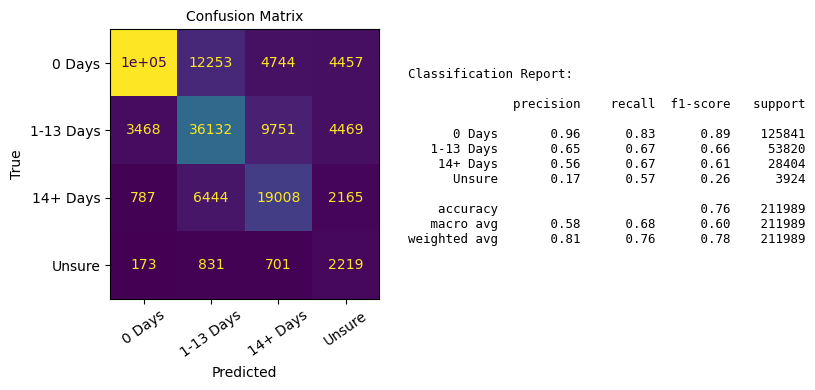

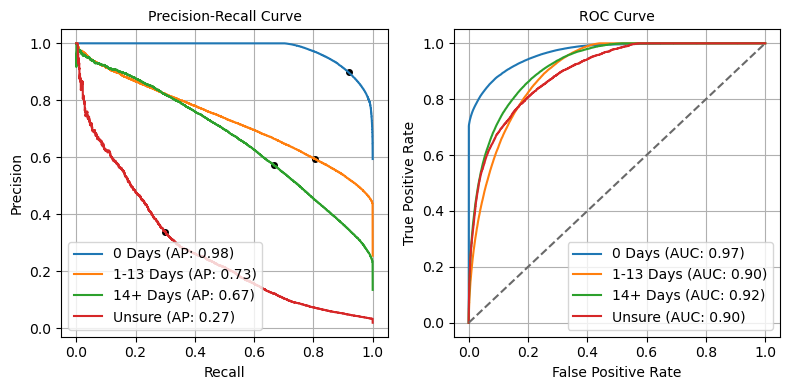

Execution Time: 2.86 seconds.


In [15]:
from sklearn.metrics import classification_report, accuracy_score

start = time.perf_counter()

# Predict on the test set
y_pred = model.predict(x_test)
y_probs = model.predict_proba(x_test)

# Evaluate performance
utils.plot_classification_stats2(y_test, y_pred, utils.target_class_mapping.values())
utils.plot_pr_roc_curve(y_test, y_probs)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

CatBoost is comparable to LightGBM and XGBoost, with overall accuracy (76.11%) slightly lower than XGBoost.
Its recall for Unsure is higher than the other two models, which might make it better in identifying such cases.
However, it still struggles with the "Unsure" class compared to LightGBM.

The consistent performance across LightGBM, XGBoost, and CatBoost suggests that the dataset is relatively stable, with similar accuracy and F1-scores. However, improvements could focus on addressing the "Unsure", and even the "14+ Days" class through targeted feature engineering or class balancing techniques.

Get Most Important Features (>0.1).

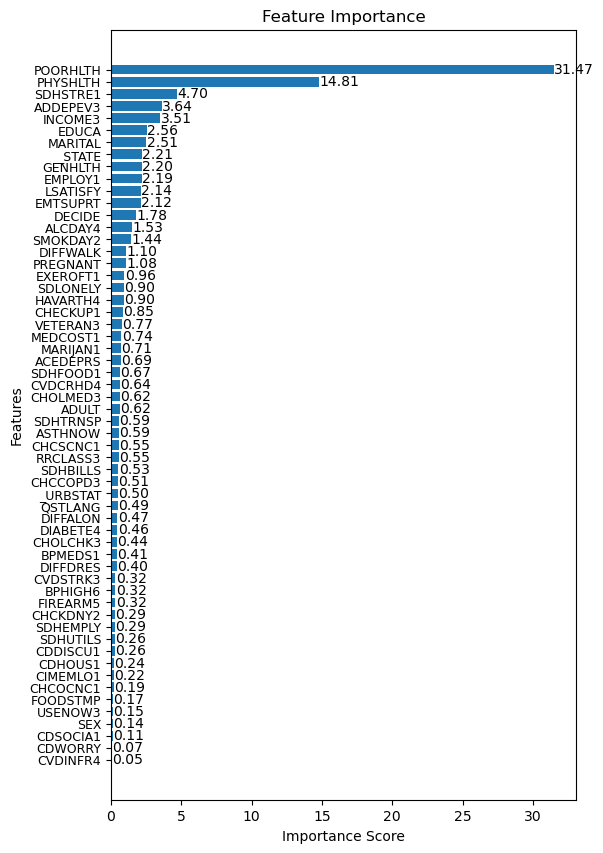

In [16]:
# Get feature importance
feature_importance = model.get_feature_importance()
# Sort features by importance score, print output
fi = {}
fi_g = {}
for col, score in zip(X.columns, feature_importance):
    if score > 0.1:
        fi[col] = score
    fi_g[col] = score
fi = dict(sorted(fi.items(), key=lambda x: x[1], reverse=True))
fi_g = dict(sorted(fi_g.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(6, 10))
bars = plt.barh(list(fi_g.keys()), list(fi_g.values()), align='center')
for bar in bars:
    plt.text(
        bar.get_width() + 0.02,  
        bar.get_y() + bar.get_height() / 2,  # Centered horizontally
        f"{bar.get_width():.2f}",  
        va='center'
    )
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.yticks(fontsize=9)
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for a descending order visual
plt.show()
    

Top Features:
- POORHLTH (46.03) is by far the most important feature, indicating it plays a critical role in the model's predictions.
- PHYSHLTH (17.10) is the second most important feature but is substantially less impactful than POORHLTH.
- Features beyond the top two drop below 6 in importance, suggesting diminishing marginal contributions to the model.

Mid-Tier Features:
- Features like SDHSTRE1, ADDEPEV3, INCOME3, and EMPLOY1 show moderate importance, indicating they may capture relevant but less dominant relationships in the data.

Lower-Tier Features:
- Features ranked below 20 (e.g., DIFFWALK, MARIJAN1) have much lower scores (< 0.6), meaning they likely contribute little to predictions.

Potential Redundancy:
- Features with very low scores (e.g., CDSOCIA1 at 0.063) might be candidates for removal in future iterations or dimensionality reduction.


### 6. Preparing the Winning Model, XGBoost

Prepare the dataset with included features identified from the previous operation.

#### 6.1 Create a new Datframe with the Selected Features

In [17]:
fr_columns = list(fi.keys()) + [target]
df = mh_df[fr_columns]
list(df.columns)

['POORHLTH',
 'PHYSHLTH',
 'SDHSTRE1',
 'ADDEPEV3',
 'INCOME3',
 'EDUCA',
 'MARITAL',
 '_STATE',
 'GENHLTH',
 'EMPLOY1',
 'LSATISFY',
 'EMTSUPRT',
 'DECIDE',
 'ALCDAY4',
 'SMOKDAY2',
 'DIFFWALK',
 'PREGNANT',
 'EXEROFT1',
 'SDLONELY',
 'HAVARTH4',
 'CHECKUP1',
 'VETERAN3',
 'MEDCOST1',
 'MARIJAN1',
 'ACEDEPRS',
 'SDHFOOD1',
 'CVDCRHD4',
 'CHOLMED3',
 'ADULT',
 'SDHTRNSP',
 'ASTHNOW',
 'CHCSCNC1',
 'RRCLASS3',
 'SDHBILLS',
 'CHCCOPD3',
 '_URBSTAT',
 'QSTLANG',
 'DIFFALON',
 'DIABETE4',
 'CHOLCHK3',
 'BPMEDS1',
 'DIFFDRES',
 'CVDSTRK3',
 'BPHIGH6',
 'FIREARM5',
 'CHCKDNY2',
 'SDHEMPLY',
 'SDHUTILS',
 'CDDISCU1',
 'CDHOUS1',
 'CIMEMLO1',
 'CHCOCNC1',
 'FOODSTMP',
 'USENOW3',
 'SEX',
 'CDSOCIA1',
 '_MENT14D']

#### 6.2 Add Composite Features into the Dataframe

In [18]:
# Create a new copy of the cleaned dataset
_df = df.copy()

mental_health_features = ['EMTSUPRT', 'ADDEPEV3', 'POORHLTH']
# Using Nonlinear interaction
_df['Physical_Mental_Interaction'] = _df['GENHLTH'].astype(int) * _df['PHYSHLTH'] 
# Income and Education Interaction
_df['Income_Education_Interaction'] = _df['INCOME3'].astype(int) * _df['EDUCA'].astype(int)
# Mental Health
_df['Mental_Health_Composite'] = _df[mental_health_features].mean(axis=1)

aggregated_features = [
  'Mental_Health_Composite',
  'Income_Education_Interaction', 
  'Physical_Mental_Interaction',
]

#### 6.3 Prepare Training, Validation, and Test Sets

In [24]:
# Numeric features need scaler
continuous_features = ['PHYSHLTH', 'POORHLTH', 'MARIJAN1']
# One-hot encode categoricals
categorical_features = [col for col in _df.columns if col not in (aggregated_features + continuous_features + [target])]
# Create predictors and target DF.

# Create predictors and target DF.
X = _df.drop(columns=[target])
y = _df[target]

# Split into validation, test datasets
X_train, x_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

_y_train = utils.target_label_mapping(y=y_train)
_y_test = utils.target_label_mapping(y=y_test)
_y_val = utils.target_label_mapping(y=y_val)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(_y_train), y=_y_train)
class_weights_dict = dict(enumerate(class_weights))
sample_weight = np.array([class_weights_dict[class_label] for class_label in _y_train])

#### 6.4 Hyperparameter Tuning the Model

In [25]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

start = time.perf_counter()

# DMatrix for XGBoost
_x_train = xgb.DMatrix(X_train, label=_y_train, enable_categorical=True) 
_x_val = xgb.DMatrix(x_val, label=_y_val, enable_categorical=True)

# Define Bayesian optimization function
def xgb_eval(max_depth, learning_rate, num_boost_round, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda):
  params = {
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'num_class': 4,
    'max_depth': int(max_depth), 
    'learning_rate': learning_rate,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'gamma': gamma,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
  }

  model = xgb.train(params, _x_train, num_boost_round=int(num_boost_round), evals=[(_x_val, 'eval')], verbose_eval=False)
  
  # Predict probabilities
  y_pred_probs = model.predict(_x_val)

  # Compute log-loss
  return -log_loss(_y_val, y_pred_probs)

# Bounds for hyperparameters
param_bounds = {
  'num_boost_round': [100, 300], # n_estimators in XGBoostClassifier
  'max_depth': [3, 10],
  'learning_rate': [0.01, 0.1],
  'subsample': [0.6, 1.0],
  'colsample_bytree': [0.6, 1.0],
  'gamma': [0, 5],
  'reg_alpha': [0, 1],
  'reg_lambda': [1, 5],
}

# Bayesian optimization
optimizer = BayesianOptimization(f=xgb_eval, pbounds=param_bounds, random_state=42, verbose=False)

# Run the optimization tasks then extract optimized results
optimizer.maximize(init_points=5, n_iter=25)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')

Execution Time: 6 minutes and 54.98 seconds.


Get best parameter values.

In [26]:

# Best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])  # Ensure max_depth is an integer
best_params['num_boost_round'] = int(best_params['num_boost_round'])
best_params['learning_rate'] = float(best_params['learning_rate'])
best_params['subsample'] = float(best_params['subsample'])
best_params['colsample_bytree'] = float(best_params['colsample_bytree'])
best_params['gamma'] = int(best_params['gamma'])
best_params['reg_alpha'] = float(best_params['reg_alpha'])
best_params['reg_lambda'] = int(best_params['reg_lambda'])

print("Best Parameters:", best_params)


Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'num_boost_round': 209, 'reg_alpha': 1.0, 'reg_lambda': 1, 'subsample': 1.0}


#### 6.5 Train and Validate the Model with the Optimized Hyperparameter.

Final Log-Loss: 0.44083243712150566


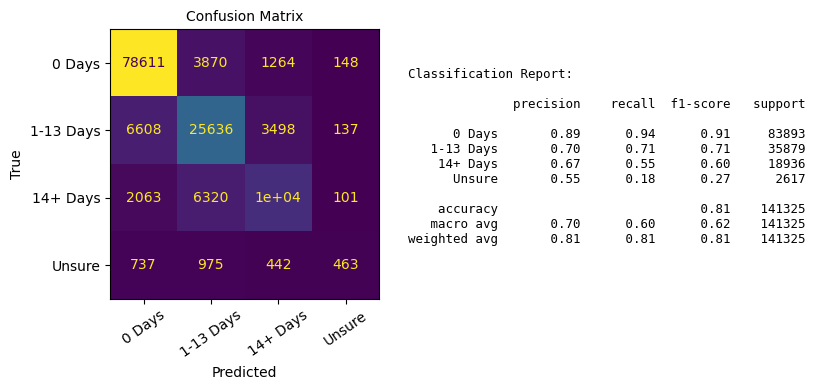

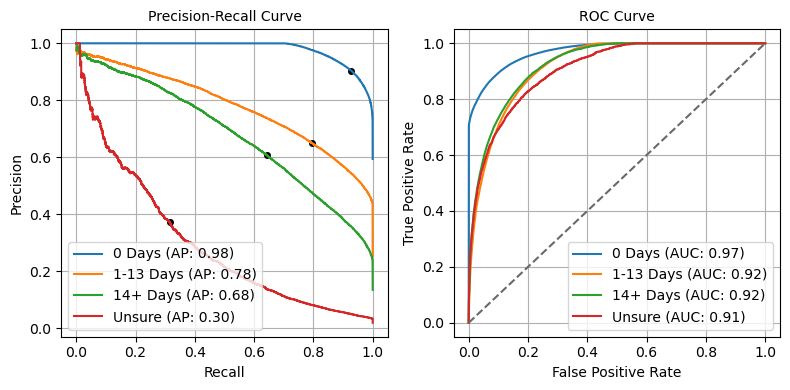

In [27]:

# Train model with best parameters
params = {
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'num_class': 4,
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
}
num_boost_round = best_params['num_boost_round']
# Train model
model_xgb = xgb.train(params, _x_train, num_boost_round=int(num_boost_round))

# Predict
y_pred_probs = model_xgb.predict(_x_val)
y_pred = y_pred_probs.argmax(axis=1)

# Evaluate
final_log_loss = log_loss(_y_val, y_pred_probs)
print("Final Log-Loss:", final_log_loss)

class_names = utils.alt_target_class_mapping.values()
utils.plot_classification_stats2(_y_val, y_pred, class_names, alt=False)
utils.plot_pr_roc_curve(_y_val, y_pred_probs)


After applying the optimized hyperparameters, including the addition of aggregated features, the accuracy increased from 76 to 81. However, the recall rate for the minority classes declined.

To address this, we will apply target class weighting to offset the imbalance and improve the recall rate for greater stability.


#### 6.6 Class Imbalance Strategy

Create a new model with optimized hyperparameters and a class-weighting strategy

Log-Loss: 0.5528574965472286


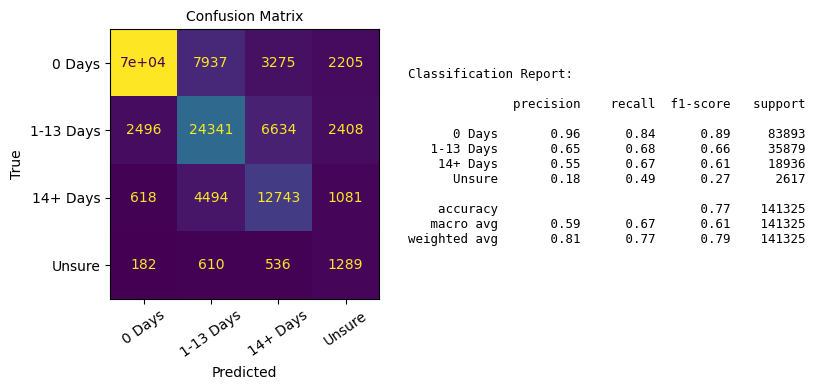

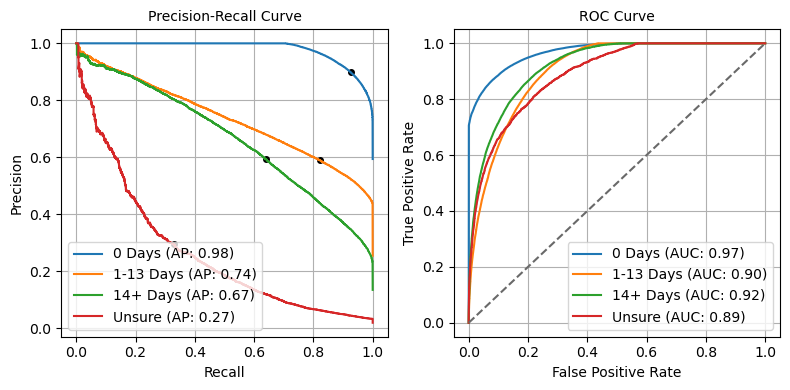

Execution Time: 18.54 seconds.


In [28]:
start = time.perf_counter()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(_y_train), y=_y_train)
class_weights_dict = dict(enumerate(class_weights))
sample_weight = np.array([class_weights_dict[class_label] for class_label in _y_train])

# Convert data into DMatrix
_x_train = xgb.DMatrix(X_train, label=_y_train, enable_categorical=True, weight=sample_weight)
_x_val = xgb.DMatrix(x_val, label=_y_val, enable_categorical=True)

# Train the model
model_xgb = xgb.train(params, _x_train, num_boost_round=int(num_boost_round), )

# Predict
y_pred_probs = model_xgb.predict(_x_val)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class predictions

final_log_loss = log_loss(_y_val, y_pred_probs)
print("Log-Loss:", final_log_loss)

utils.plot_classification_stats2(_y_val, y_pred, class_names, alt=False)
utils.plot_pr_roc_curve(_y_val, y_pred_probs)

print(f'Execution Time: {get_elapsed(start, time.perf_counter())}.')


The accuracy decreased from 0.81 to 0.77.

The updated log loss of 0.55 after addressing target imbalance indicates that while the model’s predictive power for minority classes improved, the overall probability have slightly degraded.

This drop in accuracy is a tradeoff we are willing to accept as we aim to optimize for recall, given the imbalanced minority classes. The improvement in recall for minority classes indicates that the model is now better at identifying these cases, which is crucial for mental health diagnosis.

In [29]:
import joblib

joblib.dump(model_xgb, 'models/xgb_classifier_optimized_model.pkl')

['models/xgb_classifier_optimized_model.pkl']

### 7. Adjusting Thresholds Using Cost-Benefit Analysis

In this experiment, we want to find out the optimal cost-benefit threshold for the model by assigning cost values to false positives (FP) and false negatives (FN), as well as benefit values to true positives (TP) for each target class. We will evaluate a range of thresholds to identify the optimal point that minimizes costs while maximizing benefits.

The cost-benefit threshold is our decision-making mechanism that will weigh the cost of a false positive (FP) and false negative (FN) against the benefit of true positives (TP). This threshold is critical for adjusting the tradeoff between precision and recall, especially when the consequences of errors differ significantly.

Our goal is to develop a strategy for defining and applying threshold adjustments to maximize the model's positive predictions needed for mental health prediction.

#### 7.1 Derive the Global Cost and Net-Benefit 


Evaluate using the validation dataset:

In [30]:
# Get predictions for the validation set
y_val_prob = y_pred_probs

Calculate the total cost-benefit for each of the defined thresholds then plot the output.

The total cost-benefit constitutes the aggregated contribution of costs and benefits of all the classes.


In [31]:
from sklearn.metrics import confusion_matrix

# Assign FP and FN costs, benefits for each class
costs_matrix = {
    0: {'fp': 50, 'fn': 200, 'tp': 200},
    1: {'fp': 100, 'fn': 500, 'tp': 500},
    2: {'fp': 300, 'fn': 1000, 'tp': 1000},
    3: {'fp': 0, 'fn': 0, 'tp': 10}  # Minimal cost for Class 3
}


Optimal Threshold (Min Cost): 0.30, Minimum Cost: 18395800.0
Optimal Threshold (Max Net Benefit): 0.30, Maximum Net Benefit: 20644470.0
Cost-Benefit Net Differece: 2248670.000


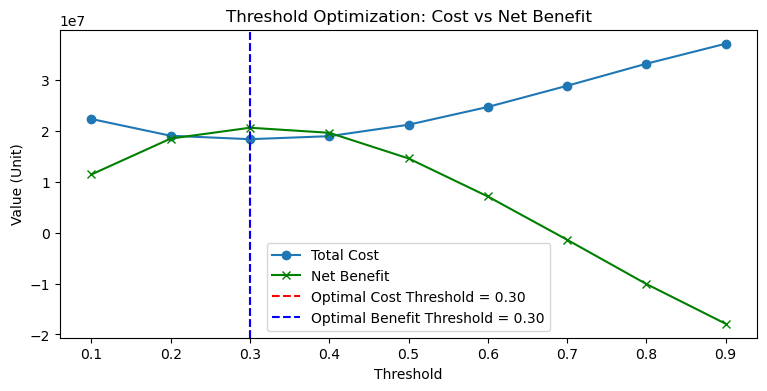

In [42]:

# Define the threshold range to 
thresholds = np.linspace(0.1, 0.9, 9)

optimal_costs = []
optimal_net_benefits = []

_y_val = utils.target_label_mapping(y=y_val)

# Evaluate each threshold for total cost and net-benefit
for threshold in thresholds:
    # Get predicted classes with applied threshold
    y_pred = np.argmax(y_val_prob >= threshold, axis=1)
    # Generate matrix
    cm = confusion_matrix(_y_val, y_pred) #, labels=[0, 1, 2, 3])

    total_cost = 0
    net_benefit = 0
    total_fp = 0
    total_fn = 0
    total_tp = 0
    
    # Calculate cost and net-benefit for each class
    for i, costs in costs_matrix.items():

        fp_cost = float(costs['fp'])
        fn_cost = float(costs['fn'])
        tp_ben = float(costs['tp'])

        tp = cm[i, i]
        fp = cm[:, i].sum() - tp  # False positives
        fn = cm[i, :].sum() - tp  # False negatives

        total_cost += (fp * fp_cost) + (fn * fn_cost) # Get total cost of errors
        net_benefit += (tp * tp_ben) - (fp * fp_cost) - (fn * fn_cost) # Get total benefit of positive prediction

        # Get totals for this threshold
        total_tp += tp
        total_fp += fp
        total_fn += fn

    optimal_costs.append((threshold, total_cost))
    optimal_net_benefits.append((threshold, net_benefit, total_cost, total_tp, total_fp, total_fn))

# Get the optimal threshold for minimum cost
opt_th_cost, min_cost = min(optimal_costs, key=lambda x: x[1])
# Find the optimal threshold for maximum net benefit
opt_th_benefit, max_net_benefit, _, _, _, _ = max(optimal_net_benefits, key=lambda x: x[1])

print(f'Optimal Threshold (Min Cost): {opt_th_cost:.2f}, Minimum Cost: {min_cost}')
print(f'Optimal Threshold (Max Net Benefit): {opt_th_benefit:.2f}, Maximum Net Benefit: {max_net_benefit}')
print(f'Cost-Benefit Net Difference: {max_net_benefit - min_cost:.3f}')

# Visualization

threshold_values, cost_values = zip(*optimal_costs)
_, benefit_values, _, _, _, _ = zip(*optimal_net_benefits)

plt.figure(figsize=(9, 4))
plt.plot(threshold_values, cost_values, marker='o', label='Total Cost')
plt.plot(threshold_values, benefit_values, marker='x', label='Net Benefit', color='g')
plt.axvline(opt_th_cost, color='r', linestyle='--', label=f'Optimal Cost Threshold = {opt_th_cost:.2f}')
plt.axvline(opt_th_benefit, color='b', linestyle='--', label=f'Optimal Benefit Threshold = {opt_th_benefit:.2f}')
plt.title('Threshold Optimization: Cost vs Net Benefit')
plt.xlabel('Threshold')
plt.ylabel('Value (Unit)')
plt.legend()
plt.show()

The Cost/Net-benefit diagram shows the relationship of total cost and net benefit across different threshold. 

Highlighted are the optimal points for minimizing cost and maximizing net benefit.

The threshold of 0.30 is the optimal threshold, balancing cost minimization and benefit maximization.
At this threshold:
- The total cost is lowest.
- The net benefit is highest, exceeding 2×10⁷, which indicates that the model adds significant value.
- The alignment of these metrics validates the threshold's effectiveness.

##### 7.1.1 Cost-Benefit Table

In [33]:
from IPython.display import display, HTML

columns = ['Threshold', 'Net Benefit', 'Total Cost', 'TP', 'FP', 'FN']
df = pd.DataFrame(optimal_net_benefits, columns=columns)
# Format decimals and add comma separators
df['Threshold'] = df['Threshold'].map('{:.1f}'.format)
df['Net Benefit'] = df['Net Benefit'].map('{:,.0f}'.format)
df['Total Cost'] = df['Total Cost'].map('{:,.0f}'.format) 
df['TP'] = df['TP'].map('{:,}'.format)
df['FP'] = df['FP'].map('{:,}'.format) 
df['FN'] = df['FN'].map('{:,}'.format)

styled_df = df.head(5).style.set_table_styles([
  {'selector': 'table', 'props': [('width', '100%'), ('margin-left', 'auto'), ('margin-right', 'auto')]},
  {'selector': 'th, td', 'props': [('padding', '8px 10px'), ('text-align', 'right'), ('font-size', '15px'), ('height', '20px')]},
  {'selector': 'th', 'props': [('background-color', '#f2f2f2')]}
])

styled_df

,Threshold,Net Benefit,Total Cost,TP,FP,FN
0,0.1,"11,466,370","22,356,500","111,269","30,056","30,056"
1,0.2,"18,519,990","19,065,750","113,590","27,735","27,735"
2,0.3,"20,644,470","18,395,800","112,228","29,097","29,097"
3,0.4,"19,653,250","18,984,300","110,563","30,762","30,762"
4,0.5,"14,611,080","21,236,350","108,008","33,317","33,317"


- The net benefit increases as the threshold rises from 0.1 to 0.3, peaking at 20,644,470 at 0.3.
After the peak, the net benefit decreases for thresholds 0.4 and 0.5.
- The total cost decreases as the threshold increases from 0.1 to 0.3, reaching a minimum of 18,395,800 at 0.3. The cost increases slightly at 0.4 and significantly at 0.5.
- True positives (TP) are highest at a threshold of 0.2 (113,590) and decrease consistently as the threshold increases beyond 0.2.

The net difference (The maximum net-benefit minus the minimum total cost) is 2,248,670 units, indicating a positive outcome, as the total benefits exceed the total costs by this amount.



The aggregated cost and benefits across thresholds provides a broad summary but doesn't directly assist in adjusting thresholds to maximize recall. 

- In the next exercise, we are going to investigate the cost-benefit of each class, and 
- apply the findings to adjust the threshold for maximizing the recall of each class.

#### 7.2 Per-Class Cost and Net-Benefits 

In the next steps, we will calculate the maximum net benefit for each class and identify the corresponding threshold (using the same range of thresholds applied in the earlier cost-benefit analysis).



Class-Wise Recall Constraint Logic:

- Class 0: "0 Days" - No Mental Stress (~60% Prevalence):
  - Class 0 is overrepresented, making it easier for the model to predict correctly.
  - A lower recall constraint (50%) is  acceptable - misclassifying false negatives is less critical.
  - Example, if someone with no stress is misclassified as having stress, the cost is lower compared to missing a stressed individual.

- Class 1: "1–13 Days" of Stress (+25% Prevalence):
  - Class 1 individuals with moderate stress needs higher priority.
  - Missing false negative cases could prevent timely intervention.
  - A higher recall constraint (80%) ensures most cases are identified, even at the expense of slightly more false positives.

- Class 2: "14+ Days" of Stress (+13% Prevalence):
  - Class 2 (critical), represents individuals with persistent stress.
  - Misclassifying these cases (false negatives) can have higher consequences (lack of appropriate support or intervention).
  - Set to the highest recall constraint (90%). Ensures almost all individuals will be correctly identified.

- Class 3: "Unsure" (~2% Prevalence):
  - Class 3, uncertainty or missing information, deems these cases less actionable.
  - A lower recall constraint (50%) as it is low priority - often less critical for decision-making.

The **recall constraint** values in a threshold adjustment strategy is critical in ensuring that the thresholds selected for each class achieve a minimum level of recall before optimizing for net benefit.

The recall constraint allows us to adjust the trade-off between recall and other metrics (recall) for each class individually.

In [188]:
# Define the threshold range 
thresholds = np.linspace(0.1, 0.9, 9) # 0.1 to 0.9 with 9 equidistant intervals

# Recall constraints. Set higher priority for minority classes.
class0_priority = 0.5   # Class0 can be lowered and set @ 50%
class1_priority = 0.8   # Class1, set @ 80%
class2_priority = 0.9   # Class2, set @ 90%
class3_priority = 0.5   # Unsure, set to lower recall

recall_constraint = {0: class0_priority, 1: class1_priority, 2: class2_priority, 3: class3_priority}
recall_constraint

{0: 0.5, 1: 0.8, 2: 0.9, 3: 0.5}

Calculate net-benefit, cost, recall, and threshold:

In [194]:
# Optimize thresholds for each class

optimal_thresholds = {}
cost_benefit_thresholds = []

for class_label, costs in costs_matrix.items():
    
    best_threshold = None
    max_net_benefit = float('-inf')
    
    for _threshold in thresholds:

        # Predict for this class at the current threshold
        threshold = _threshold
        y_pred = (y_val_prob[:, class_label] >= threshold).astype(int)
        y_prob = (_y_val == class_label).astype(int)  # Binary target for this class
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_prob, y_pred, labels=[0, 1]).ravel()
        
        # Calculate recall, precision
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        # Calculate total cost
        total_cost = (fp * costs['fp']) + (fn * costs['fn']) 
        # Calculate net benefit (adjusted for class imbalance)
        net_benefit = (tp * costs['tp']) - (fp * costs['fp']) - (fn * costs['fn'])
        # Calculate net-difference of benefit over cost (net-cost if difference is < 1)
        net_diff = net_benefit - total_cost
        #print(f'class{class_label}, th={threshold:.1f}, recall={recall:.3f}, wn_benefit={net_benefit:.3f}, wt_cost={total_cost:.3f}')

        # Apply recall constraint
        if recall >= recall_constraint[class_label]:
            # Track the best threshold for this class
            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold
                #print(f'class={class_label}, recall={recall:.3f}, best_th={best_threshold},')
                class_name = utils.alt_target_class_mapping[class_label]
                cost_benefit_thresholds.append((class_name, threshold, precision, recall, net_benefit, total_cost, net_diff, tp, tn, fp, fn))
    
    optimal_thresholds[class_label] = best_threshold
    #print(f'    NetBenefit: {max_net_benefit:.3f}, TotalCost: {total_cost:.3f}')


In [195]:
optimal_thresholds

{0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1}

##### 7.2.1 Cost-Benefit Table

In [196]:
# Tabulate classes and cost, net-benefits

columns = ['Class', 'Threshold', 'Precision', 'Recall', 'Net-Benefit', 'Cost', 'Net-Diff', 'TP', 'TN', 'FP', 'FN']
df = pd.DataFrame(cost_benefit_thresholds, columns=columns)
df['Threshold'] = df['Threshold'].map('{:.1f}'.format)
df['Precision'] = df['Precision'].map('{:.3f}'.format)
df['Recall'] = df['Recall'].map('{:.3f}'.format)
df['Net-Benefit'] = df['Net-Benefit'].map('{:,.0f}'.format)
df['Cost'] = df['Cost'].map('{:,.0f}'.format) 
total_net_difference = df['Net-Diff'].sum()
df['Net-Diff'] = df['Net-Diff'].map('{:,.0f}'.format)
df['TP'] = df['TP'].map('{:,}'.format)
df['TN'] = df['TN'].map('{:,}'.format)
df['FP'] = df['FP'].map('{:,}'.format) 
df['FN'] = df['FN'].map('{:,}'.format)

styled_df = df.head(5).style.set_table_styles([
  {'selector': 'table', 'props': [('width', '100%'), ('margin-left', 'auto'), ('margin-right', 'auto')]},
  {'selector': 'th, td', 'props': [('padding', '8px 10px'), ('text-align', 'right'), ('font-size', '15px'), ('height', '20px')]},
  {'selector': 'th', 'props': [('background-color', '#f2f2f2')]}
])

styled_df


,Class,Threshold,Precision,Recall,Net-Benefit,Cost,Net-Diff,TP,TN,FP,FN
0,0 Days,0.1,0.847,0.968,"14,961,500","1,274,900","13,686,600","81,182","42,778","14,654","2,711"
1,1-13 Days,0.1,0.484,0.968,"13,104,700","4,269,300","8,835,400","34,748","68,408","37,038","1,131"
2,14+ Days,0.1,0.306,0.962,"5,139,500","13,083,500","-7,944,000","18,223","81,154","41,235",713
3,Unsure,0.1,0.051,0.885,"23,170",0,"23,170","2,317","95,278","43,430",300


Get the total net difference.

In [197]:
# Total net-difference
print(f'Total Net Difference: {total_net_difference:,.0f} Units.')

Total Net Difference: 14,601,170 Units.


- The best threshold is 0.1 for all classes, indicating a uniform threshold strategy may work for this dataset.
- The recall values are relatively on the higher range for the first 3 classes, Class 3 is slightly lower.
- Net Benefit and Total Cost vary widely among classes, reflecting the differing importance or impact of predictions in each class.

The net difference is 14,601,170 units, indicating a positive outcome, as the total benefits exceed the total costs.

#### 7.3 Applying the Optimized Thresholds on the Validation Data

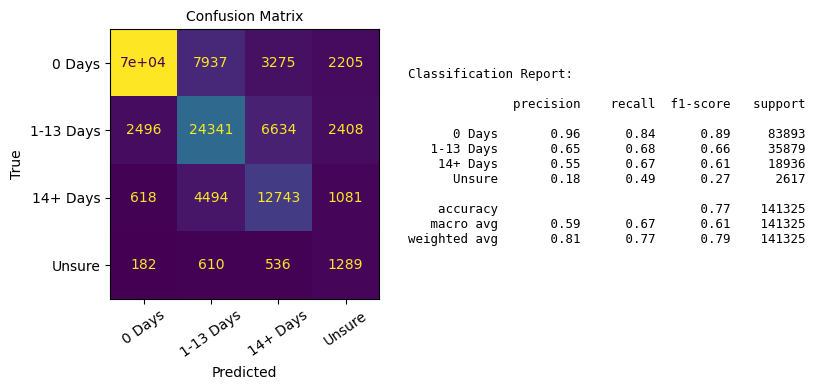

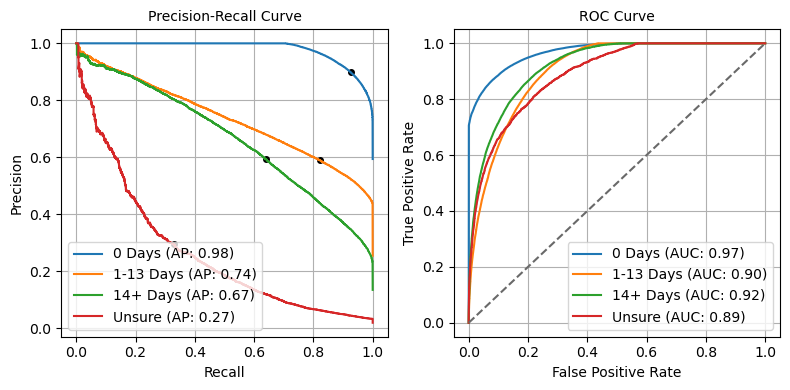

In [77]:
# Get prediction and probabilities
y_pred, y_prob = xgb_predict_with_threshold(model_xgb, x_val, _y_val, optimal_thresholds)

class_names = utils.alt_target_class_mapping.values()
utils.plot_classification_stats2(_y_val, y_pred, class_names, True)
utils.plot_pr_roc_curve(_y_val, y_prob)

The metrics are the same as when the model predictions were made without applying Threshold Adjustments. 

Applying the class weights during model training already optimized the decision boundary and threshold implicitly. 
As a result, further threshold adjustments may not significantly impact the model's performance.

#### 7.4 Applying the Optimized Thresholds on the Test Data.

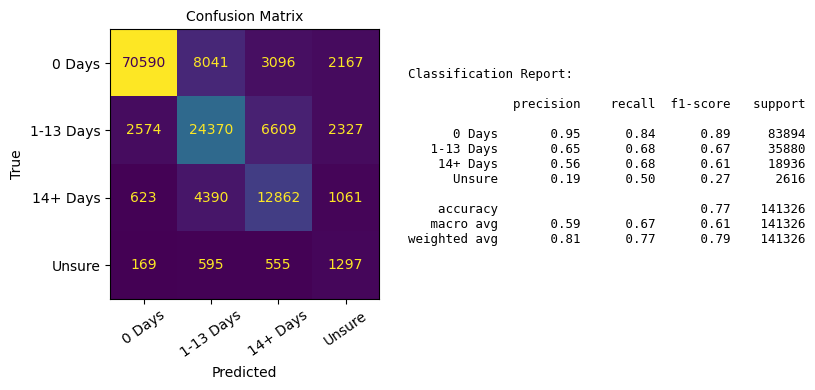

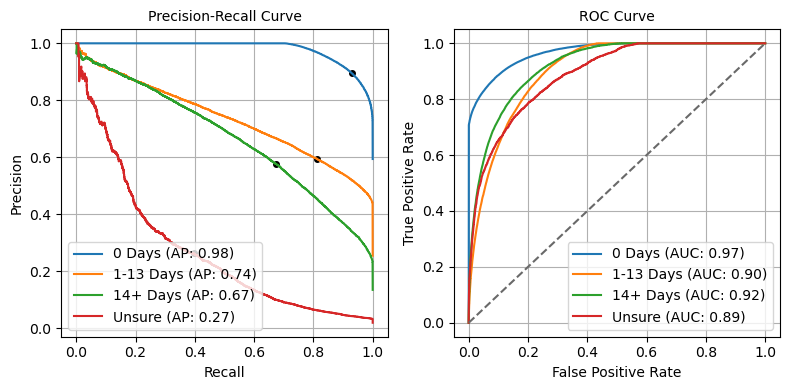

In [107]:
y_pred, y_prob = xgb_predict_with_threshold(model_xgb, x_test, _y_test, optimal_thresholds)

class_names = utils.alt_target_class_mapping.values()
utils.plot_classification_stats2(_y_test, y_pred, class_names, True)
utils.plot_pr_roc_curve(_y_test, y_prob)

- The test AUC scores remains the same as the validation AUC scores, it indicates that the rank ordering of probabilities generated by the model is the same, and the threshold adjustment did not affect the underlying model's discrimination ability.
- The identical F1 scores suggest that the adjusted thresholds did not alter the actual predicted classes, meaning the thresholds had little or no effect on the test data's probability distributions.

The strategies applied during training and validation: sample_weight; cost-benefit thresholds, feature engineering have generalized well to the unseen test data. This indicates that the model is not overfitting or underfitting.

The model is performing consistently across validation and test datasets. This strongly indicates that the model is ready for deployment, if the current performance meets business or project goals.


### 8. Summary

Models Performance:

- Logistic Regression has the lowest accuracy (63%) and struggles with minority class predictions.
- Random Forest achieves an accuracy of 80% with improved F1 for major classes.
- LightGBM and XGBoost show better results but require threshold optimization for cost-benefit trade-offs.
- CatBoost is introduced to validate imbalances and see if we need to improve precision and recall metrics. Its performance is compared against previous models.

XGBoost came out as the best model for deployment, with better gains in accuracy, recall, and overall metrics performance.

- Features were reduced to the most relevant subset based on feature importance scores and a minimum importance score of 0.1 or greater.
- Composite feature engineering added meaningful predictors, boosting the model's interpretability and predictive accuracy.
- Training with the refined dataset optimized the balance between overfitting and generalization.
- Threshold adjustments using cost-benefit analysis fine-tuned predictions.

The introduction of composite features and cost-benefit thresholding proved crucial to achieving these improvements.

- While the model excels in "0 Days" and "1-13 Days" predictions, 
- further work is recommended for refining predictions in the "14+ Days" and "Unsure" classes.

Cost-Benefit Analysis:

  - Global:
    - Optimal Thresholds: Tested at various points (0.1 to 0.5).
    - Net Benefit Peak: Achieved at a threshold of 0.3, with a Net Benefit of 70.
    - Trade-offs: As thresholds increase:
      True Positives (TP): Peak at a threshold of 0.3 with 340 TP, then decline.
      False Positives (FP): Gradually decrease as thresholds increase, reaching a minimum at 0.3.
      False Negatives (FN): Minimized around 0.3 but increase at higher thresholds.
    - The net difference is **2,248,670** units, indicating a positive outcome, as the total benefits exceed the total cost.

  - Per-Class:
    - The best threshold is 0.1 for all classes, indicating a uniform threshold strategy may work for this dataset.
    - The recall values are relatively on the higher range for the first 3 classes, Class 3 ("14+ Days")is slightly lower.
    - Net Benefit and Total Cost vary widely among classes, reflecting the differing importance or impact of predictions in each class.
    - The net difference is **14,601,170** units, indicating a positive outcome, as the total benefits exceed the total cost.

      

### 9. Recommendations

The final model could be considered fit for limited deployment focusing on the "0 Days" and "1-13 Days" classes, provided that the following recommendations are implemented to mitigate the identified limitations. The following plan safeguards for the limitations of the model while allowing the system to provide actionable insights. 

1. Human-in-the-Loop Validation: 
- Model predictions for Classes 1, 2, and 3 should flag cases for expert review rather than being final decisions.
- A team of clinicians or mental health experts should review flagged predictions to validate and prioritize interventions.
- This minimizes risks associated with false positives, especially for Classes 2 and 3.

2. Intervention Plan and Resource Allocation:
- Design an intervention plan commensurate to the confidence and importance of the prediction(s).
- High-confidence predictions for Class 2 with >0.7 probability: Allocate maximum resources (therapy outreach, immediate support).
- Medium-confidence predictions for Class 1 with 0.5-0.7 probability: Allocate moderate resources (surveys, preliminary counseling).
- Low-confidence predictions for Class 3: Delay action and collect additional data for improved prediction.
- This ensures limited resources are used efficiently while maintaining operational credibility.

3. Feedback Loop:
- Continuously monitor and improve model performance post-deployment.
- Collect data from actual interventions to identify patterns in false positives and false negatives.
- Retrain the model periodically using updated data that reflects real-world trends.
- Set up monitoring for data drift to detect if the input data distribution changes over time.
- Mental health data is dynamic, and ensuring the model adapts to changing patterns is critical.

4. Clearly Communicate the Model Limitations:
- Make it clear to stakeholders that the model supports, but does not replace, clinical judgment.
- Develop, provide user guidelines explaining how to interpret the predictions and the potential risks (false positives).
- Label predictions with confidence levels ("High confidence prediction for Class 1: 0.75").
- Transparency fosters trust and prevents misuse of predictions.

Defined Deployment Plan:

1. Deploy in a Staged Environment:
- Start with pilot deployment:
- Focus on specific classes (Classes 0 and 1) in controlled settings, such as a single clinic or region.
- Gradually expand deployment to include all classes as confidence in predictions improves.

2. Monitoring and Reporting
- Set up real-time dashboards to monitor:
- Precision, recall, false positives, and false negatives by class.
- Intervention outcomes based on predictions (how many flagged individuals were correctly identified as needing support).

3. Develop Automated Alerts for Critical Predictions:
- For Classes 2 and 3 (where misclassifications have high consequences), trigger alerts for immediate review.
- For example: Alert is sent to a counselor if the model predicts "14+ days" with a confidence score above 0.6.

4. Integrate with Existing Workflows:
- Ensure the model integrates seamlessly into existing mental health systems:
- Patient records.
- Counseling scheduling systems.
- Feedback loops for updating the model with outcomes.

5. Ethical and Regulatory Considerations:
- In mental health prediction, ethical considerations should be high priority:
- Avoiding Harm: Ensure the system does not stigmatize individuals by overestimating mental health issues (Classes 2 and 3 false positives).
- Data Privacy: Comply with regulations like HIPAA to protect sensitive patient data.
- Bias Mitigation: Conduct fairness analysis to ensure the model performs equitably across demographics (gender, ethnicity).

6. Evaluation Metrics:
- To evaluate the effectiveness of the contingencies:
- Precision improvement for Classes 1, 2, and 3 after threshold adjustment.
- Reduction in false positives for Classes 2 and 3 post-deployment.
- User feedback from clinicians or mental health experts on flagged cases.
- Resource utilization rates aligned with predicted severity levels.

### 10. Conclusion

Deploying the mental health classification model is valuable if it is complemented by a detailed workflow plan such as mental-health experts validation, threshold adjustment, and continous feedback. 

For a mental health application, the stakes are high, and ensuring the system complements expert judgment is critical. With these strategies, we can deploy the model responsibly while iterating to improve its reliability.
